# EDA for MCC Aggregates Forecasting

Focused exploratory data analysis for transaction forecasting by categories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load data
print("Loading transaction data...")
df = pd.read_csv('../data/transactions_data.csv')
print(f"Loaded {len(df):,} transactions")

# Load MCC mapping
with open('../data/mcc_mapping.json', 'r') as f:
    mcc_mapping = json.load(f)

print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Loading transaction data...
Loaded 13,305,915 transactions
Data shape: (13305915, 12)
Date range: 2010-01-01 00:01:00 to 2019-10-31 23:59:00


In [3]:
# Data preprocessing
df['date'] = pd.to_datetime(df['date'])
df['amount'] = df['amount'].str.replace('$', '').astype(float)
df['mcc'] = df['mcc'].astype(str)

# Create reverse mapping from MCC to category
mcc_to_category = {}
for category, info in mcc_mapping['categories'].items():
    for mcc_code in info['mcc_codes']:
        mcc_to_category[mcc_code] = category

# Map MCC codes to categories
df['category'] = df['mcc'].map(mcc_to_category).fillna('other')

print("Sample data after preprocessing:")
print(df[['date', 'client_id', 'amount', 'mcc', 'category']].head())

Sample data after preprocessing:
                 date  client_id  amount   mcc   category
0 2010-01-01 00:01:00       1556  -77.00  5499       food
1 2010-01-01 00:02:00        561   14.57  5311     retail
2 2010-01-01 00:02:00       1129   80.00  4829  financial
3 2010-01-01 00:05:00        430  200.00  4829  financial
4 2010-01-01 00:06:00        848   46.41  5813       food


In [4]:
# Basic statistics
print("=== BASIC STATISTICS ===")
print(f"Unique clients: {df['client_id'].nunique():,}")
print(f"Unique categories: {df['category'].nunique()}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")

print("\nTransaction amounts:")
print(df['amount'].describe())

=== BASIC STATISTICS ===
Unique clients: 1,219
Unique categories: 17
Date range: 2010-01-01 to 2019-10-31
Total days: 3590

Transaction amounts:
count    1.330592e+07
mean     4.297604e+01
std      8.165575e+01
min     -5.000000e+02
25%      8.930000e+00
50%      2.899000e+01
75%      6.371000e+01
max      6.820200e+03
Name: amount, dtype: float64


In [5]:
# Category distribution
print("=== CATEGORY ANALYSIS ===")
category_stats = df.groupby('category').agg({
    'amount': ['count', 'sum', 'mean', 'std'],
    'client_id': 'nunique'
}).round(2)

category_stats.columns = ['transactions', 'total_amount', 'avg_amount', 'std_amount', 'unique_clients']
category_stats = category_stats.sort_values('total_amount', ascending=False)

print("Top categories by volume:")
print(category_stats.head(10))

=== CATEGORY ANALYSIS ===
Top categories by volume:
               transactions  total_amount  avg_amount  std_amount  \
category                                                            
food                4930301  1.036339e+08       21.02       39.18   
retail              1526770  8.765744e+07       57.41       61.23   
transport           2706892  7.780817e+07       28.74       62.67   
utilities            612144  6.123793e+07      100.04       72.61   
services             818813  5.596490e+07       68.35      118.50   
financial            589140  5.315852e+07       90.23       41.99   
specialty            793155  3.679704e+07       46.39       46.80   
industrial           206033  3.182656e+07      154.47      361.82   
entertainment        326879  2.083082e+07       63.73       95.58   
health               113121  1.875120e+07      165.76      138.43   

               unique_clients  
category                       
food                     1219  
retail                 

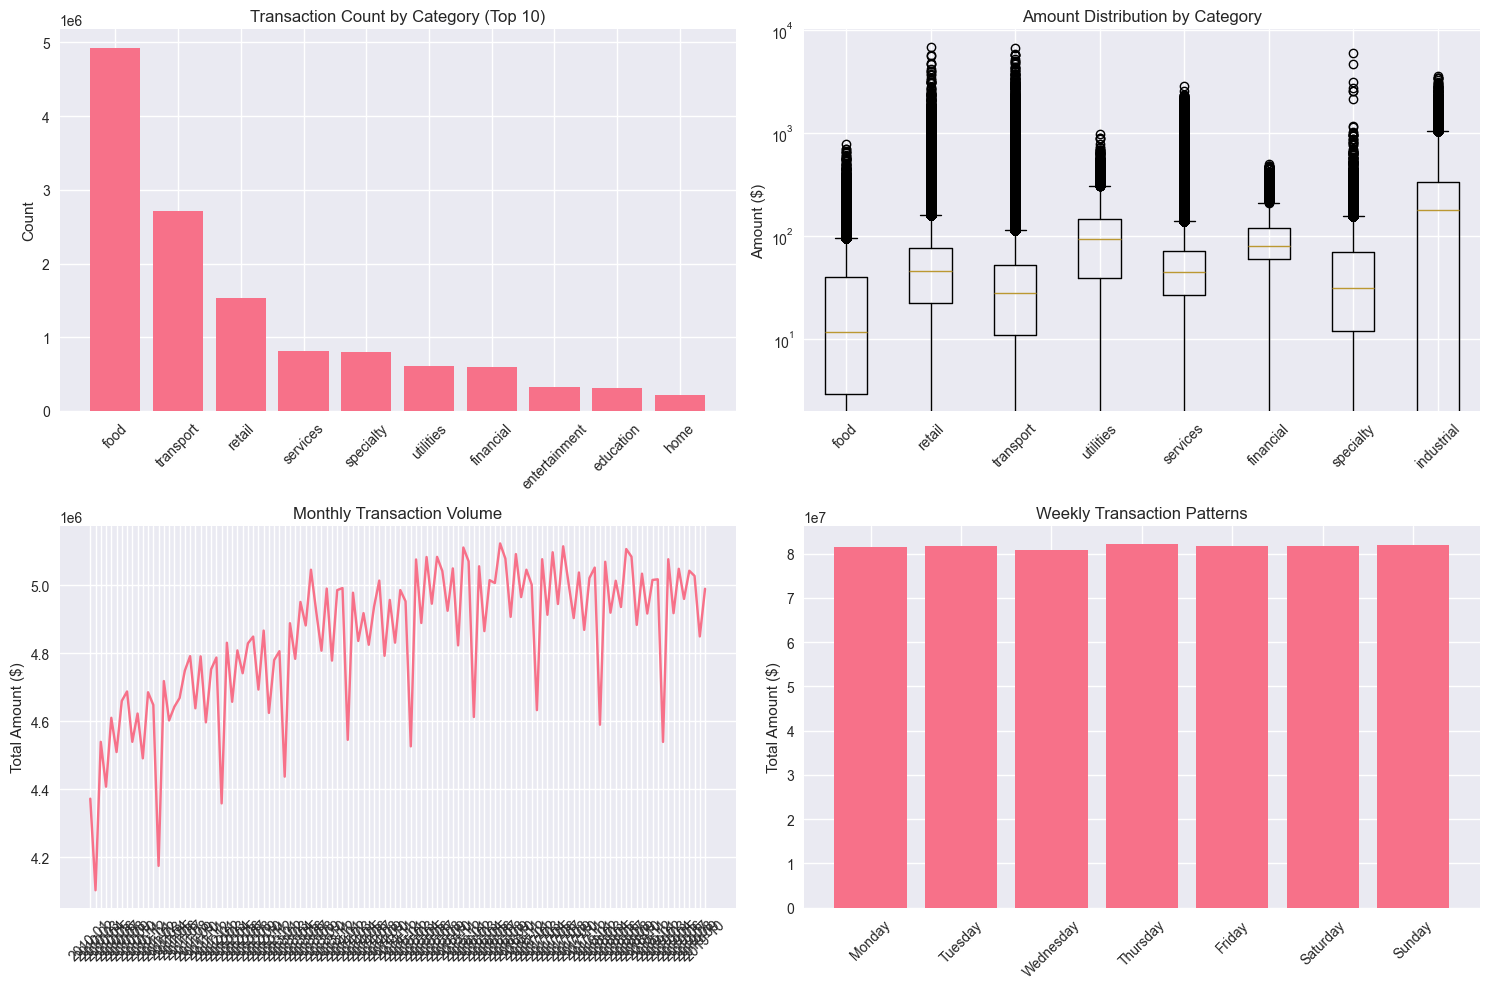

In [6]:
# Visualization: Category distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Transaction count by category
category_counts = df['category'].value_counts().head(10)
axes[0,0].bar(range(len(category_counts)), category_counts.values)
axes[0,0].set_xticks(range(len(category_counts)))
axes[0,0].set_xticklabels(category_counts.index, rotation=45)
axes[0,0].set_title('Transaction Count by Category (Top 10)')
axes[0,0].set_ylabel('Count')

# Amount distribution by category
top_categories = category_stats.head(8).index
df_top = df[df['category'].isin(top_categories)]
axes[0,1].boxplot([df_top[df_top['category']==cat]['amount'].values for cat in top_categories])
axes[0,1].set_xticklabels(top_categories, rotation=45)
axes[0,1].set_title('Amount Distribution by Category')
axes[0,1].set_ylabel('Amount ($)')
axes[0,1].set_yscale('log')

# Monthly transaction volume
df['month'] = df['date'].dt.to_period('M')
monthly_volume = df.groupby('month')['amount'].sum()
axes[1,0].plot(monthly_volume.index.astype(str), monthly_volume.values)
axes[1,0].set_title('Monthly Transaction Volume')
axes[1,0].set_ylabel('Total Amount ($)')
axes[1,0].tick_params(axis='x', rotation=45)

# Weekly patterns
df['weekday'] = df['date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_volume = df.groupby('weekday')['amount'].sum().reindex(weekday_order)
axes[1,1].bar(weekday_volume.index, weekday_volume.values)
axes[1,1].set_title('Weekly Transaction Patterns')
axes[1,1].set_ylabel('Total Amount ($)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Time series analysis for forecasting
print("=== TIME SERIES ANALYSIS ===")

# Create weekly aggregates by client and category
df['week'] = df['date'].dt.to_period('W')
weekly_data = df.groupby(['client_id', 'category', 'week'])['amount'].sum().reset_index()

print(f"Weekly aggregates shape: {weekly_data.shape}")

# Series length analysis
series_lengths = weekly_data.groupby(['client_id', 'category']).size()
print(f"\nSeries length statistics:")
print(series_lengths.describe())

# Filter series for forecasting (≥ 104 weeks as per requirements)
min_length = 104
valid_series = series_lengths[series_lengths >= min_length]
print(f"\nSeries with ≥{min_length} weeks: {len(valid_series)} out of {len(series_lengths)} ({len(valid_series)/len(series_lengths)*100:.1f}%)")

=== TIME SERIES ANALYSIS ===
Weekly aggregates shape: (3776239, 4)

Series length statistics:
count    19515.000000
mean       193.504432
std        172.853339
min          1.000000
25%         28.000000
50%        146.000000
75%        336.000000
max        514.000000
dtype: float64

Series with ≥104 weeks: 11057 out of 19515 (56.7%)


In [8]:
# Non-zero ratio analysis
print("=== NON-ZERO RATIO ANALYSIS ===")

def calculate_nonzero_ratio(group):
    return (group['amount'] > 0).mean()

# Calculate non-zero ratios for valid series
valid_pairs = valid_series.index
nonzero_ratios = weekly_data.set_index(['client_id', 'category']).loc[valid_pairs].groupby(['client_id', 'category']).apply(calculate_nonzero_ratio)

print("Non-zero ratio statistics:")
print(nonzero_ratios.describe())

# Filter by non-zero ratio (≥ 30% as per requirements)
min_nonzero_ratio = 0.30
final_series = nonzero_ratios[nonzero_ratios >= min_nonzero_ratio]
print(f"\nSeries with ≥{min_nonzero_ratio*100}% non-zero ratio: {len(final_series)} out of {len(nonzero_ratios)} ({len(final_series)/len(nonzero_ratios)*100:.1f}%)")

=== NON-ZERO RATIO ANALYSIS ===
Non-zero ratio statistics:
count    11057.000000
mean         0.993580
std          0.046496
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

Series with ≥30.0% non-zero ratio: 11040 out of 11057 (99.8%)


In [9]:
# Final dataset for forecasting
print("=== FORECASTING DATASET ===")

# Create final filtered dataset
final_pairs = final_series.index
forecasting_data = weekly_data.set_index(['client_id', 'category']).loc[final_pairs].reset_index()

print(f"Final forecasting dataset: {len(forecasting_data)} records")
print(f"Unique client-category pairs: {len(final_pairs)}")

# Category distribution in final dataset
final_category_dist = forecasting_data['category'].value_counts()
print(f"\nCategory distribution in final dataset:")
print(final_category_dist)

=== FORECASTING DATASET ===
Final forecasting dataset: 3503629 records
Unique client-category pairs: 11040

Category distribution in final dataset:
category
food             584689
retail           500931
transport        461577
services         391333
specialty        366452
utilities        354237
financial        226354
entertainment    196318
education        179440
home             120656
health            49598
freight           39204
industrial        30263
sports             2577
Name: count, dtype: int64


=== SAMPLE TIME SERIES ===


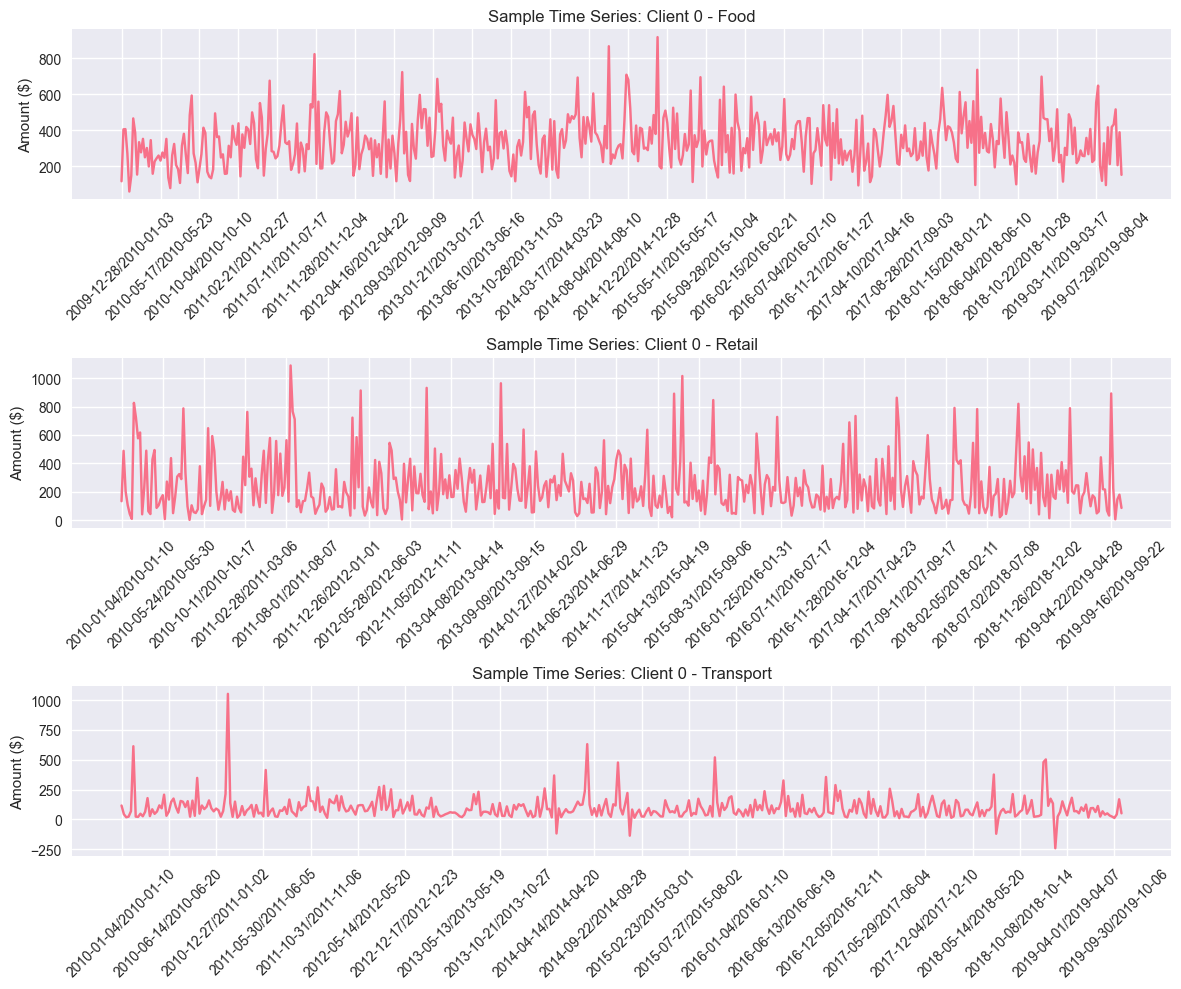

In [10]:
# Sample time series visualization
print("=== SAMPLE TIME SERIES ===")

# Select top 3 categories for visualization
top_3_categories = final_category_dist.head(3).index

fig, axes = plt.subplots(3, 1, figsize=(12, 10))

for i, category in enumerate(top_3_categories):
    # Get a sample client for this category
    sample_client = forecasting_data[forecasting_data['category'] == category]['client_id'].iloc[0]
    
    # Get time series data
    ts_data = forecasting_data[
        (forecasting_data['client_id'] == sample_client) & 
        (forecasting_data['category'] == category)
    ].sort_values('week')
    
    axes[i].plot(ts_data['week'].astype(str), ts_data['amount'])
    axes[i].set_title(f'Sample Time Series: Client {sample_client} - {category.title()}')
    axes[i].set_ylabel('Amount ($)')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Show only every 20th tick for readability
    ticks = axes[i].get_xticks()
    axes[i].set_xticks(ticks[::20])

plt.tight_layout()
plt.show()

In [11]:
# Summary statistics for forecasting
print("=== FORECASTING SUMMARY ===")
print(f"Total transactions: {len(df):,}")
print(f"Unique clients: {df['client_id'].nunique():,}")
print(f"Categories: {df['category'].nunique()}")
print(f"Time span: {(df['date'].max() - df['date'].min()).days} days")
print(f"Weekly aggregates: {len(weekly_data):,}")
print(f"Valid series (≥{min_length} weeks): {len(valid_series):,}")
print(f"Final series (≥{min_nonzero_ratio*100}% non-zero): {len(final_series):,}")
print(f"Forecasting dataset size: {len(forecasting_data):,} records")

print("\nReady for forecasting model development!")

=== FORECASTING SUMMARY ===
Total transactions: 13,305,915
Unique clients: 1,219
Categories: 17
Time span: 3590 days
Weekly aggregates: 3,776,239
Valid series (≥104 weeks): 11,057
Final series (≥30.0% non-zero): 11,040
Forecasting dataset size: 3,503,629 records

Ready for forecasting model development!
